**Classificando radiografias pulmonares com Rede Convolucional**


O dataset foi obtido a partir do link: https://data.mendeley.com/datasets/rscbjbr9sj/2

São radiografias do peito de pacientes, dividos em pastas de treino e teste, as duas situações:

> NORMAL: Sem pneumonia

> PNEUMONIA: Com pneumonia bacteriana ou viral

Após o dataset ser baixado, a divisão entre treino e teste foi desfeita.

Foi percebido que as imagens com pneumonia tinham no nome, se eram pneumonia viral ou bacteriana.

Então, a fim de tentar expandir o alcance desse trabalho, a classe PNEUMONIA foi divida manualmente, em duas subclasses: PNEUMONIA_VIRUS e PNEUMONIA_BACTERIA.

Por último, o dataset foi carregado no kaggle: https://www.kaggle.com/datasets/vitorpiress/chest-x-ray-classification

As classes ficaram:

> PNEUMONIA_VIRUS: Classe 0 (com pneumonia viral)

> PNEUMONIA_BACTERIA: Classe 1 (com pneumonia bacteriana)

> NORMAL: Classe 2

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-x-ray-classification/chest_xray/PNEUMONIA_VIRUS/VIRUS-4670779-0001.jpeg
/kaggle/input/chest-x-ray-classification/chest_xray/PNEUMONIA_VIRUS/VIRUS-7398476-0002.jpeg
/kaggle/input/chest-x-ray-classification/chest_xray/PNEUMONIA_VIRUS/VIRUS-2110654-0002.jpeg
/kaggle/input/chest-x-ray-classification/chest_xray/PNEUMONIA_VIRUS/VIRUS-8750763-0002.jpeg
/kaggle/input/chest-x-ray-classification/chest_xray/PNEUMONIA_VIRUS/VIRUS-149789-0001.jpeg
/kaggle/input/chest-x-ray-classification/chest_xray/PNEUMONIA_VIRUS/VIRUS-8302418-0001.jpeg
/kaggle/input/chest-x-ray-classification/chest_xray/PNEUMONIA_VIRUS/VIRUS-4217562-0002.jpeg
/kaggle/input/chest-x-ray-classification/chest_xray/PNEUMONIA_VIRUS/VIRUS-5861843-0003.jpeg
/kaggle/input/chest-x-ray-classification/chest_xray/PNEUMONIA_VIRUS/VIRUS-9624424-0002.jpeg
/kaggle/input/chest-x-ray-classification/chest_xray/PNEUMONIA_VIRUS/VIRUS-5632296-0002.jpeg
/kaggle/input/chest-x-ray-classification/chest_xray/PNEUMONIA_VIRUS/VIRUS-7795904

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, MaxPooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import random
import shutil
from PIL import Image
from collections import Counter
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
from torch.autograd import Variable
import numpy as np
from tensorflow.keras.optimizers import Adam

2024-02-08 16:24:23.134418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 16:24:23.134559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 16:24:23.299579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
src_dir = '/kaggle/input/chest-x-ray-classification/chest_xray'
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'
val_dir = '/kaggle/working/val'

train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2

labels = ['PNEUMONIA_VIRUS', 'PNEUMONIA_BACTERIA', 'NORMAL']

def split_data(src, train, test, val, train_ratio, test_ratio, val_ratio):
    for class_label in labels:
        class_folder = os.path.join(src, class_label)
        if os.path.isdir(class_folder):
            files = [file for file in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, file))]
            total_files = len(files)
            random.shuffle(files)

            train_size = int(total_files * train_ratio)
            test_size = int(total_files * test_ratio)
            val_size = int(total_files * val_ratio)

            train_files = files[:train_size]
            test_files = files[train_size:(train_size + test_size)]
            val_files = files[(train_size + test_size):(train_size + test_size + val_size)]

            for directory in [os.path.join(train, class_label), os.path.join(test, class_label), os.path.join(val, class_label)]:
                if not os.path.exists(directory):
                    os.makedirs(directory)

            for file in train_files:
                shutil.copy(os.path.join(class_folder, file), os.path.join(train, class_label, file))

            for file in test_files:
                shutil.copy(os.path.join(class_folder, file), os.path.join(test, class_label, file))

            for file in val_files:
                shutil.copy(os.path.join(class_folder, file), os.path.join(val, class_label, file))

split_data(src_dir, train_dir, test_dir, val_dir, train_ratio, test_ratio, val_ratio)

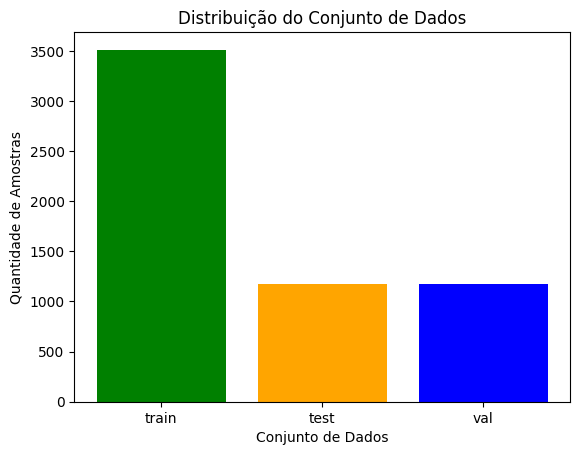

In [4]:
def plot_dataset_distribution(train_dir, test_dir, val_dir):
    train_count = sum([len(files) for _, _, files in os.walk(train_dir)])
    test_count = sum([len(files) for _, _, files in os.walk(test_dir)])
    val_count = sum([len(files) for _, _, files in os.walk(val_dir)])

    labels = ['train', 'test', 'val']
    counts = [train_count, test_count, val_count]

    plt.bar(labels, counts, color=['green', 'orange', 'blue'])
    plt.xlabel('Conjunto de Dados')
    plt.ylabel('Quantidade de Amostras')
    plt.title('Distribuição do Conjunto de Dados')
    plt.show()

train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'
val_dir = '/kaggle/working/val'

plot_dataset_distribution(train_dir, test_dir, val_dir)

In [ ]:
#def clear_directory(directory):
#    try:
#        shutil.rmtree(directory)
#        print(f"Conteúdo de {directory} removido com sucesso.")
#    except FileNotFoundError:
#        print(f"O diretório {directory} não existe.")
#    except Exception as e:
#        print(f"Erro ao remover conteúdo de {directory}: {e}")

#clear_directory(train_dir)
#clear_directory(test_dir)
#clear_directory(val_dir)

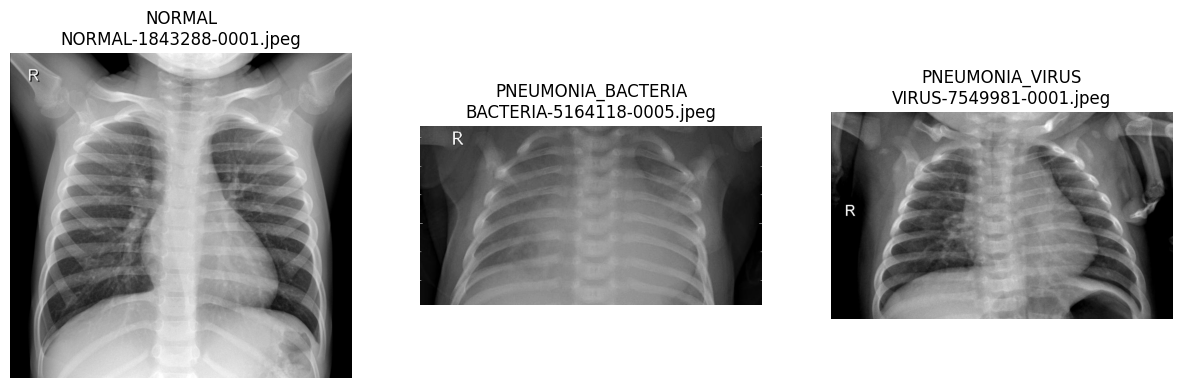

In [5]:
def show_specific_images(directory, labels, num_images=1):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    class_mapping = {
        'NORMAL': 'NORMAL',
        'PNEUMONIA_BACTERIA': 'PNEUMONIA_BACTERIA',
        'PNEUMONIA_VIRUS': 'PNEUMONIA_VIRUS'
    }

    for i, (class_name, filename) in enumerate(labels.items()):
        class_dir = os.path.join(directory, class_mapping[class_name])
        filepath = os.path.join(class_dir, filename)
        image = Image.open(filepath)
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'{class_name}\n{filename}')

    plt.show()

labels_train = {
    'NORMAL': 'NORMAL-1843288-0001.jpeg',
    'PNEUMONIA_BACTERIA': 'BACTERIA-5164118-0005.jpeg',
    'PNEUMONIA_VIRUS': 'VIRUS-7549981-0001.jpeg'
}

show_specific_images(train_dir, labels_train, num_images=3)

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_data(directory, x, y, label):
    for filename in os.listdir(directory):
        img = load_img(os.path.join(directory, filename), target_size=(224, 224))
        img_array = img_to_array(img)
        x.append(img_array)
        y.append(label)


x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

load_data(os.path.join(train_dir, 'PNEUMONIA_VIRUS'), x_train, y_train, 0)
load_data(os.path.join(train_dir, 'PNEUMONIA_BACTERIA'), x_train, y_train, 1)
load_data(os.path.join(train_dir, 'NORMAL'), x_train, y_train, 2)

load_data(os.path.join(test_dir, 'PNEUMONIA_VIRUS'), x_test, y_test, 0)
load_data(os.path.join(test_dir, 'PNEUMONIA_BACTERIA'), x_test, y_test, 1)
load_data(os.path.join(test_dir, 'NORMAL'), x_test, y_test, 2)

load_data(os.path.join(val_dir, 'PNEUMONIA_VIRUS'), x_val, y_val, 0)
load_data(os.path.join(val_dir, 'PNEUMONIA_BACTERIA'), x_val, y_val, 1)
load_data(os.path.join(val_dir, 'NORMAL'), x_val, y_val, 2)


x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [7]:
input_shape = (224, 224, 3)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [8]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)

datagen.fit(x_train)

In [10]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(datagen.flow(x_train, y_train_one_hot, batch_size=32), 
                    epochs=12, 
                    validation_data=datagen.flow(x_val, y_val_one_hot), 
                    callbacks=[learning_rate_reduction])


Epoch 1/12
110/110 [==============================] - 265s 2s/step - loss: 11.5838 - accuracy: 0.5401 - val_loss: 0.9367 - val_accuracy: 0.6274 - lr: 0.0010
Epoch 2/12
110/110 [==============================] - 230s 2s/step - loss: 0.9079 - accuracy: 0.6139 - val_loss: 0.8647 - val_accuracy: 0.6308 - lr: 0.0010
Epoch 3/12
110/110 [==============================] - 252s 2s/step - loss: 0.8586 - accuracy: 0.6261 - val_loss: 0.8188 - val_accuracy: 0.6675 - lr: 0.0010
Epoch 4/12
110/110 [==============================] - 229s 2s/step - loss: 0.8661 - accuracy: 0.6455 - val_loss: 0.8177 - val_accuracy: 0.6496 - lr: 0.0010
Epoch 5/12
110/110 [==============================] - ETA: 0s - loss: 0.8509 - accuracy: 0.6370
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
110/110 [==============================] - 229s 2s/step - loss: 0.8509 - accuracy: 0.6370 - val_loss: 0.8438 - val_accuracy: 0.6453 - lr: 0.0010
Epoch 6/12
110/110 [==============================] - 227s

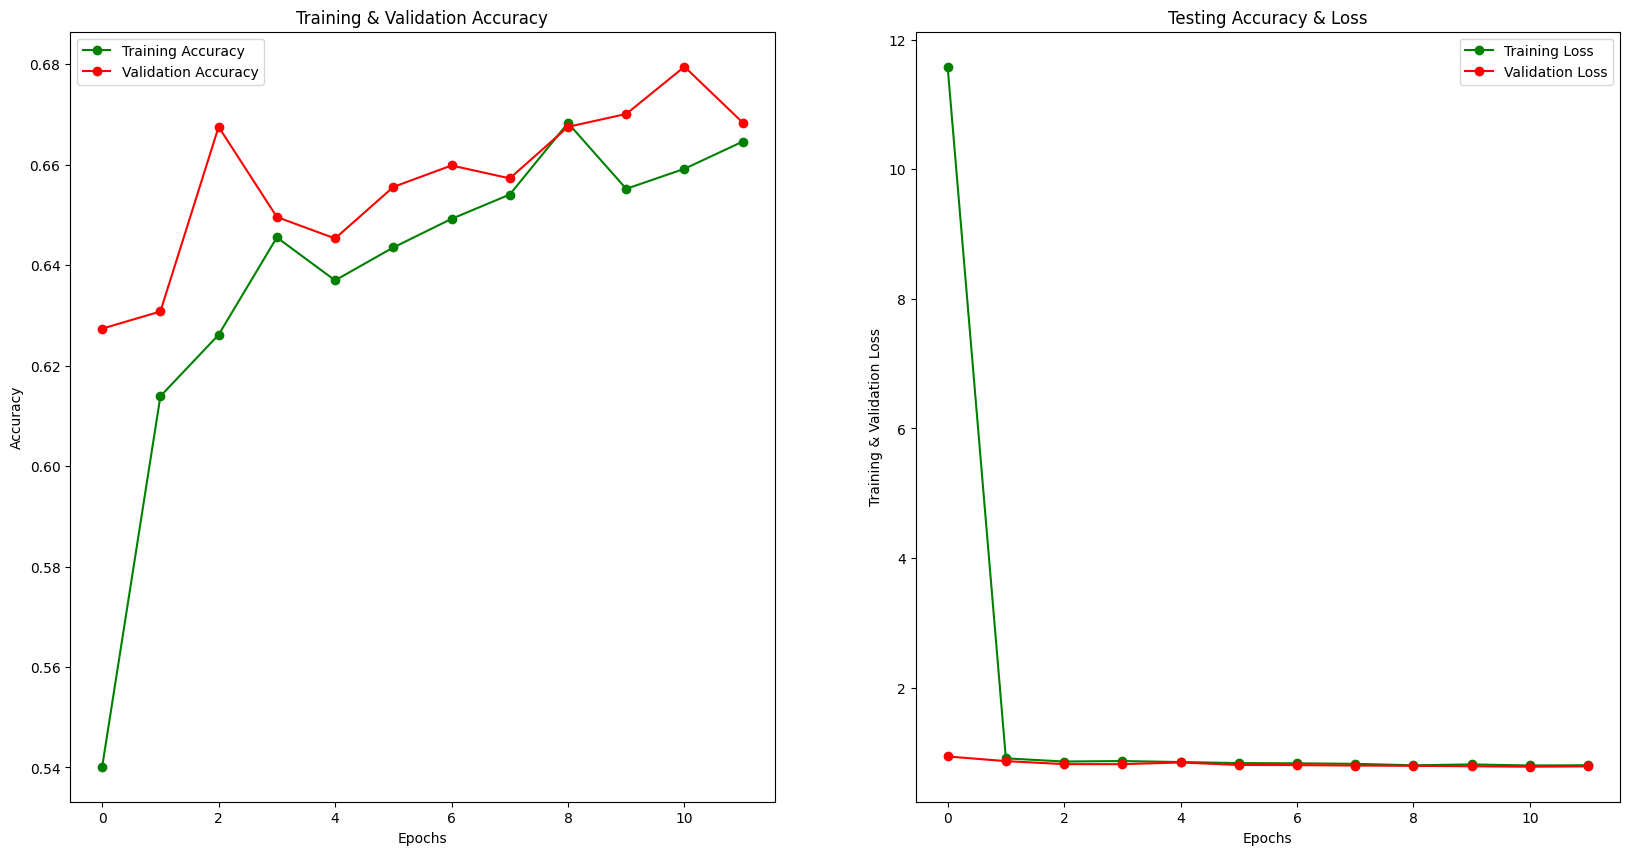

In [11]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [12]:
predictions_prob = model.predict(x_test)
predictions = predictions_prob.argmax(axis=-1)

print(predictions[:20])

37/37 [==============================] - 18s 493ms/step
[1 0 1 0 1 0 2 1 0 0 1 1 2 0 0 0 1 1 1 1]


<Axes: >

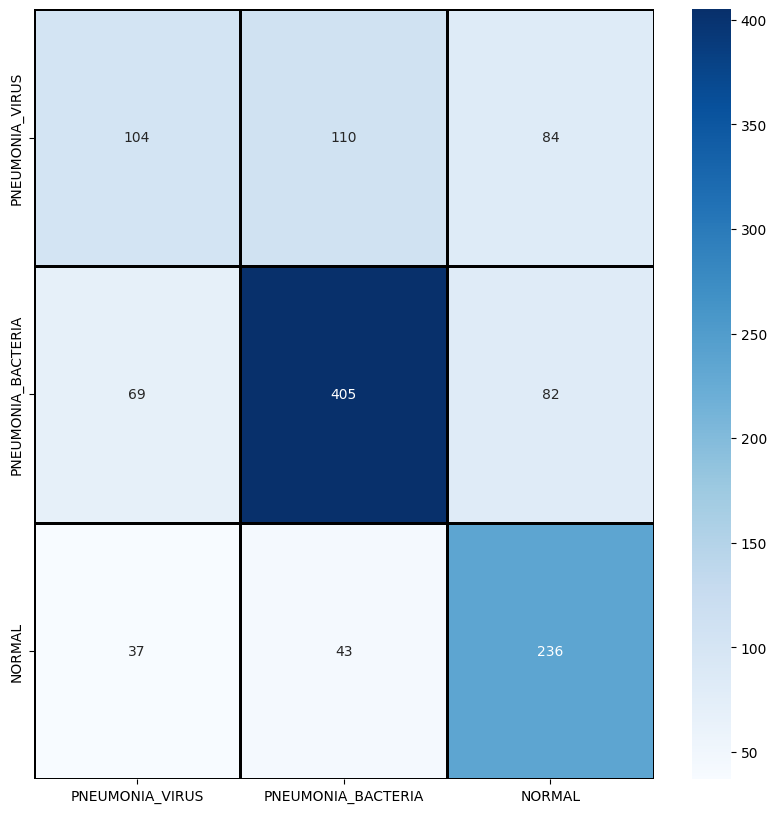

In [13]:
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

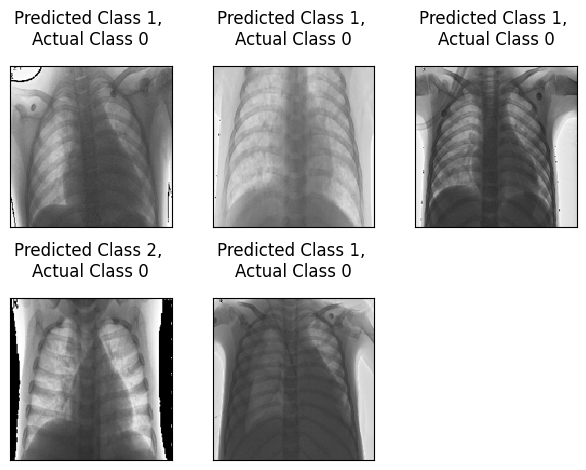

In [22]:
plt.subplots_adjust(wspace=0.5, hspace=1.5)

incorrect_class_0 = np.nonzero((predictions != y_test) & (y_test == 0))[0]
incorrect_class_1 = np.nonzero((predictions != y_test) & (y_test == 1))[0]
i = 0

for i, index in enumerate(incorrect_class_0[:5]):
    plt.subplot(2, 3, i + 1)
    plt.xticks([])
    plt.yticks([])

    img_data_uint8 = (x_test[index] * 255).astype(np.uint8)
    original_image = Image.fromarray(img_data_uint8)
    resized_image = original_image.resize((150, 150))
    reshaped_image = np.array(resized_image)

    plt.imshow(reshaped_image, cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, \nActual Class {}".format(predictions[index], y_test[index]), y=1.08)
    plt.tight_layout()

plt.show()

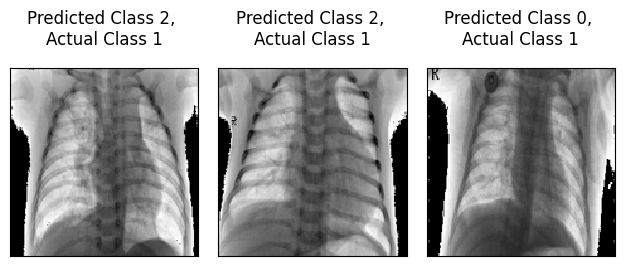

In [24]:
for i, index in enumerate(incorrect_class_1[:3]):
    plt.subplot(2, 3, i + 4)
    plt.xticks([])
    plt.yticks([])

    img_data_uint8 = (x_test[index] * 255).astype(np.uint8)
    original_image = Image.fromarray(img_data_uint8)
    resized_image = original_image.resize((150, 150))
    reshaped_image = np.array(resized_image)

    plt.imshow(reshaped_image, cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, \nActual Class {}".format(predictions[index], y_test[index]), y=1.08)
    plt.tight_layout()
    
plt.show()

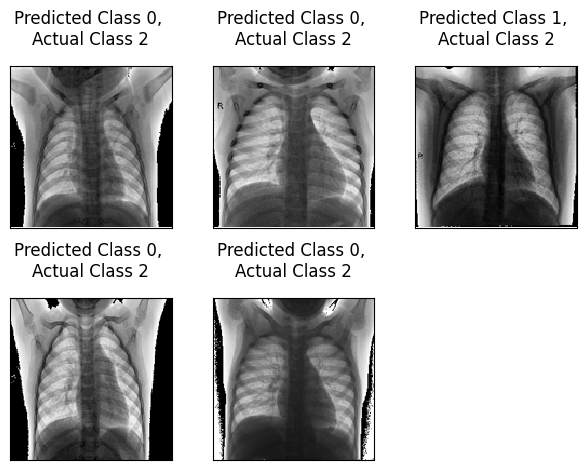

In [16]:
incorrect_class_2 = np.nonzero((predictions != y_test) & (y_test == 2))[0]

for i, index in enumerate(incorrect_class_2[:5]):
    plt.subplot(2, 3, i + 1)
    plt.xticks([])
    plt.yticks([])

    img_data_uint8 = (x_test[index] * 255).astype(np.uint8)
    
    original_image = Image.fromarray(img_data_uint8)
    resized_image = original_image.resize((150, 150))
    reshaped_image = np.array(resized_image)

    plt.imshow(reshaped_image, cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, \nActual Class {}".format(predictions[index], y_test[index]), y=1.08)
    plt.tight_layout()

plt.show()

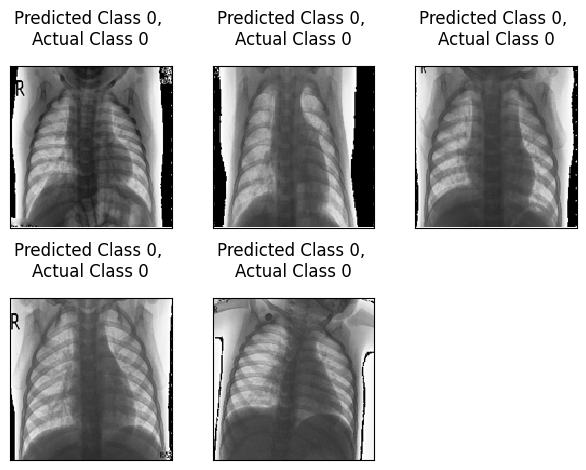

In [31]:
correct = np.nonzero(predictions == y_test)[0]

for i, index in enumerate(correct[:5]):
    plt.subplot(2, 3, i + 1)
    plt.xticks([])
    plt.yticks([])

    img_data_uint8 = (x_test[index] * 255).astype(np.uint8)
    
    original_image = Image.fromarray(img_data_uint8)
    resized_image = original_image.resize((150, 150))
    reshaped_image = np.array(resized_image)

    plt.imshow(reshaped_image, cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, \nActual Class {}".format(predictions[index], y_test[index]), y=1.08)
    plt.tight_layout()

plt.show()

In [33]:
print(classification_report(y_test, predictions, target_names = ['PNEUMONIA_VIRUS (Class 0)','PNEUMONIA_BACTERIA (Class 1)', 'NORMAL (Class 2)']))

                              precision    recall  f1-score   support

   PNEUMONIA_VIRUS (Class 0)       0.50      0.35      0.41       298
PNEUMONIA_BACTERIA (Class 1)       0.73      0.73      0.73       556
            NORMAL (Class 2)       0.59      0.75      0.66       316

                    accuracy                           0.64      1170
                   macro avg       0.60      0.61      0.60      1170
                weighted avg       0.63      0.64      0.63      1170

